<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2657 entries, 2010-06-29 to 2021-01-15
Data columns (total 7 columns):
open        2657 non-null float64
high        2657 non-null float64
low         2657 non-null float64
close       2657 non-null float64
adjclose    2657 non-null float64
volume      2657 non-null int64
ticker      2657 non-null object
dtypes: float64(5), int64(1), object(1)
memory usage: 166.1+ KB
Null values
 open        0
high        0
low         0
close       0
adjclose    0
volume      0
ticker      0
dtype: int64
Epoch 1/2
73/73 [==============================] - 5s 34ms/step - loss: 6.3546e-04

C:\Users\joao-\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\joao-\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


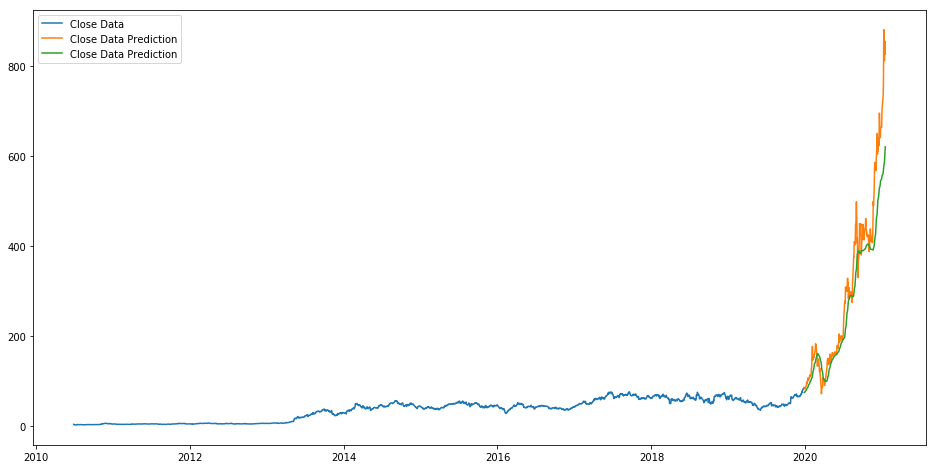

In [30]:
## Model training and performance evaluation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense
from yahoo_fin.stock_info import get_data


ticker_list = ["amzn", "aapl", "ba", "^GSPC", "nflx", "fb", "tsla", "ko", "NSRGY", "pep", "mnst"]
historical_datas = {}
for ticker in ticker_list:
    historical_datas[ticker] = get_data(ticker, index_as_date = True, interval="1d")

df = historical_datas['tsla']


df.info()
df.head()
print("Null values\n",df.isnull().sum())


#df = df.loc['2020-06-01':]
#df['Return'] = (df['Adj Close'] - df['Adj Close'].shift(1)) / df['Adj Close'].shift(1) * 100


new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['date','adjclose'])

for i in range(0,len(df)):
    new_dataset["date"][i]=df.index[i]
    new_dataset["adjclose"][i]=df["adjclose"][i]
    #new_dataset["Return"][i]= ((data['Adj Close'][i] - data['Adj Close'][i+1]) / data['Adj Close'][i+1] * 100)


scaler=MinMaxScaler(feature_range=(0,1))

final_dataset=new_dataset.values

#Get array half lenght
halfpoint = int(len(final_dataset)*.9)
train_data=final_dataset[:int(halfpoint)]
valid_data=final_dataset[int(halfpoint):]

new_dataset.index=new_dataset.date
new_dataset.drop("date",axis=1,inplace=True)

final_dataset=new_dataset.values
#SCALE
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data, =[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50, dropout=0.3))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
test_data = new_dataset[-266:].values
test_data=test_data.reshape(-1,1)
test_data=scaler.transform(test_data)

lstm_model.compile(loss='mean_squared_error',optimizer='Adam')
lstm_model.fit(x_train_data,y_train_data,epochs=2,batch_size=32,verbose=1)


X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_xtest = lstm_model.predict(x_train_data)

test_performance = predicted_closing_price
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)
predicted_xtest = scaler.inverse_transform(predicted_xtest)

lstm_model.save("new_model.h5")

train_data=new_dataset[:int(halfpoint)]
valid_data=new_dataset[int(halfpoint):]
valid_data['Predictions']=predicted_closing_price
plt.figure(figsize=(16,8))
plt.plot(train_data["adjclose"], label='Close Data')
plt.plot(valid_data[['adjclose',"Predictions"]], label='Close Data Prediction')
plt.legend()
plt.show()

# Performance evaluation on unscaled data

mae= mean_absolute_error(valid_data["adjclose"], valid_data["Predictions"])
mse = mean_squared_error(valid_data["adjclose"], valid_data["Predictions"])
rmse = np.sqrt(mse)
r2 = r2_score(valid_data["adjclose"], valid_data["Predictions"])
print(valid_data.head())
print('Mean Absolute Error: {:.2f}'.format(mae))
print('Mean Squared Error: {:.2f}'.format(mse))
print('Root Mean Squared Error: {:.2f}'.format(rmse))
print('R2 Score: ', r2)

# Performance evaluation on scaled data -- more accurate

mae= mean_absolute_error(test_performance, test_data)
mse = mean_squared_error(test_performance, test_data)
rmse = np.sqrt(mse)
r2 = r2_score(test_performance, test_data)

print('Mean Absolute Error: {:.2f}'.format(mae))
print('Mean Squared Error: {:.2f}'.format(mse))
print('Root Mean Squared Error: {:.2f}'.format(rmse))
print('R2 Score: ', r2)


[[0.21260843 0.21065232 0.2094932  ... 0.22788397 0.22971864 0.22707669]
 [0.21065232 0.2094932  0.20971056 ... 0.22971864 0.22707669 0.23074598]
 [0.2094932  0.20971056 0.20760965 ... 0.22707669 0.23074598 0.22927834]
 ...
 [0.21944466 0.2232606  0.22149934 ... 0.2221481  0.22333622 0.22496998]
 [0.2232606  0.22149934 0.2257557  ... 0.22333622 0.22496998 0.22422735]
 [0.22149934 0.2257557  0.23037907 ... 0.22496998 0.22422735 0.22370758]]
Mean Absolute Error: 3.54
Mean Squared Error: 24.10
Root Mean Squared Error: 4.91
R2 Score:  0.8666841683034721


c:\users\joao-\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


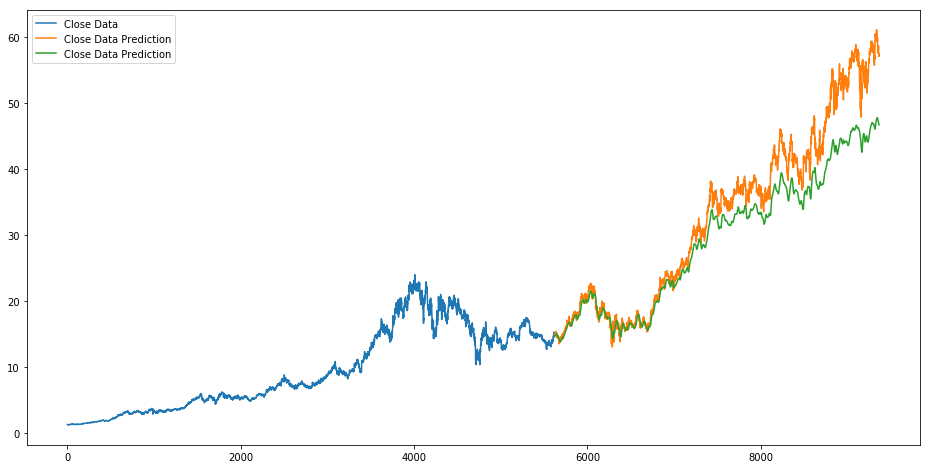

In [31]:
from datetime import datetime

def datetime_to_timestamp(x):
        return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')

ticker_list = ["amzn", "ba", "^GSPC", "nflx", "fb", "tsla", "ko", "NSRGY", "pep", "mnst", "eth-usd", "vz"]
historical_datas = {}
for ticker in ticker_list:
    historical_datas[ticker] = get_data(ticker, index_as_date = True, interval="1d")

#df=pd.read_csv("tsla.csv")
df = historical_datas['vz']
df.index = df.index.to_series().apply(datetime_to_timestamp)

data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['date','adjclose'])

for i in range(0,len(data)):
    new_dataset["date"][i]=data.index[i]
    new_dataset["adjclose"][i]=data["adjclose"][i]


scaler=MinMaxScaler(feature_range=(0,1))

final_dataset=new_dataset.values

halfpoint = int(len(final_dataset)*0.6)
train_data=final_dataset[:halfpoint]
valid_data=final_dataset[halfpoint:]

new_dataset.index=new_dataset.index
new_dataset.drop("date",axis=1,inplace=True)

final_dataset=new_dataset.values

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)


inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

print(X_test[:50])
lstm_model= load_model("new_model.h5")
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

train_data=new_dataset[:halfpoint]
valid_data=new_dataset[halfpoint:]

valid_data['Predictions']=predicted_closing_price
plt.figure(figsize=(16,8))
plt.plot(train_data["adjclose"], label='Close Data')
plt.plot(valid_data[['adjclose',"Predictions"]], label='Close Data Prediction')
plt.legend()
plt.show()

mae= mean_absolute_error(valid_data["adjclose"], valid_data["Predictions"])
mse = mean_squared_error(valid_data["adjclose"], valid_data["Predictions"])
rmse = np.sqrt(mse)
r2 = r2_score(valid_data["adjclose"], valid_data["Predictions"])


print('Mean Absolute Error: {:.2f}'.format(mae))
print('Mean Squared Error: {:.2f}'.format(mse))
print('Root Mean Squared Error: {:.2f}'.format(rmse))
print('R2 Score: ', r2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619 entries, 0 to 5618
Data columns (total 1 columns):
adjclose    5619 non-null object
dtypes: object(1)
memory usage: 44.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3747 entries, 5619 to 9365
Data columns (total 2 columns):
adjclose       3747 non-null object
Predictions    3747 non-null float32
dtypes: float32(1), object(1)
memory usage: 44.0+ KB


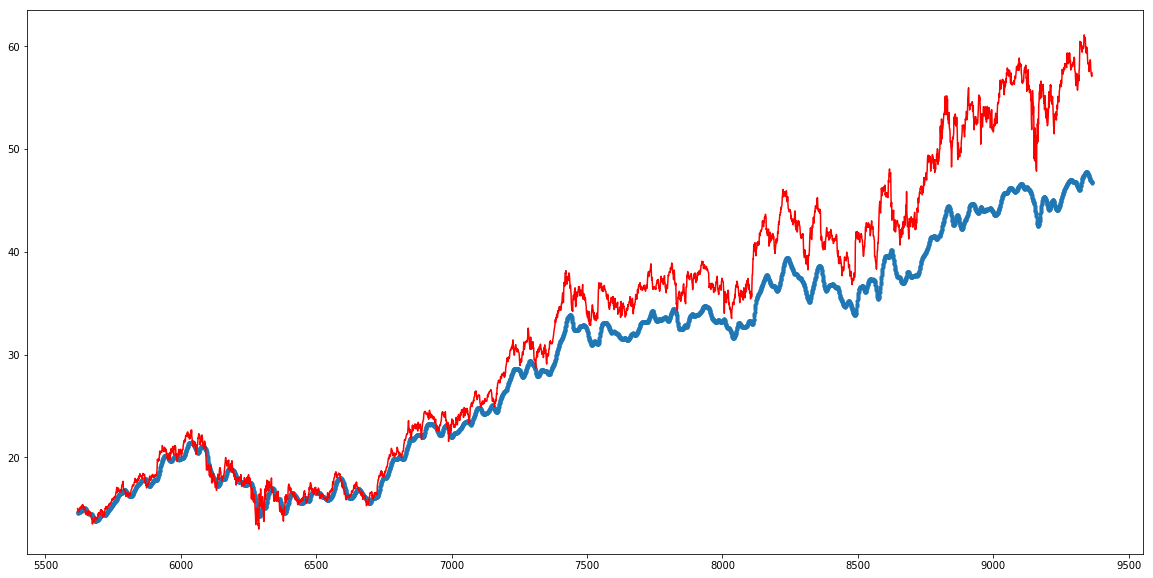

In [32]:
train_data.info()
valid_data.info()
plt.scatter(valid_data.index, valid_data["Predictions"], s=10)
plt.plot(valid_data.index, valid_data['adjclose'], color='r')
plt.show()

Description
                open          high           low         close      adjclose  \
count   2314.000000   2314.000000   2314.000000   2314.000000   2314.000000   
mean    5133.368560   5270.944785   4993.053830   5149.633159   5149.633159   
std     5426.038965   5618.598408   5227.668306   5468.588413   5468.588413   
min      176.897003    211.731003    171.509995    178.102997    178.102997   
25%      448.001991    452.453506    441.986252    447.702248    447.702248   
50%     3912.354492   3993.862061   3843.133789   3913.599365   3913.599365   
75%     8559.816162   8727.541016   8275.852539   8563.625977   8563.625977   
max    40788.640625  41946.738281  38980.875000  40797.609375  40797.609375   

             volume  
count  2.314000e+03  
mean   9.552984e+09  
std    1.392912e+10  
min    5.914570e+06  
25%    6.360970e+07  
50%    3.282610e+09  
75%    1.586698e+10  
max    1.233206e+11  

Data Correlation
               open      high       low     close  adjclose

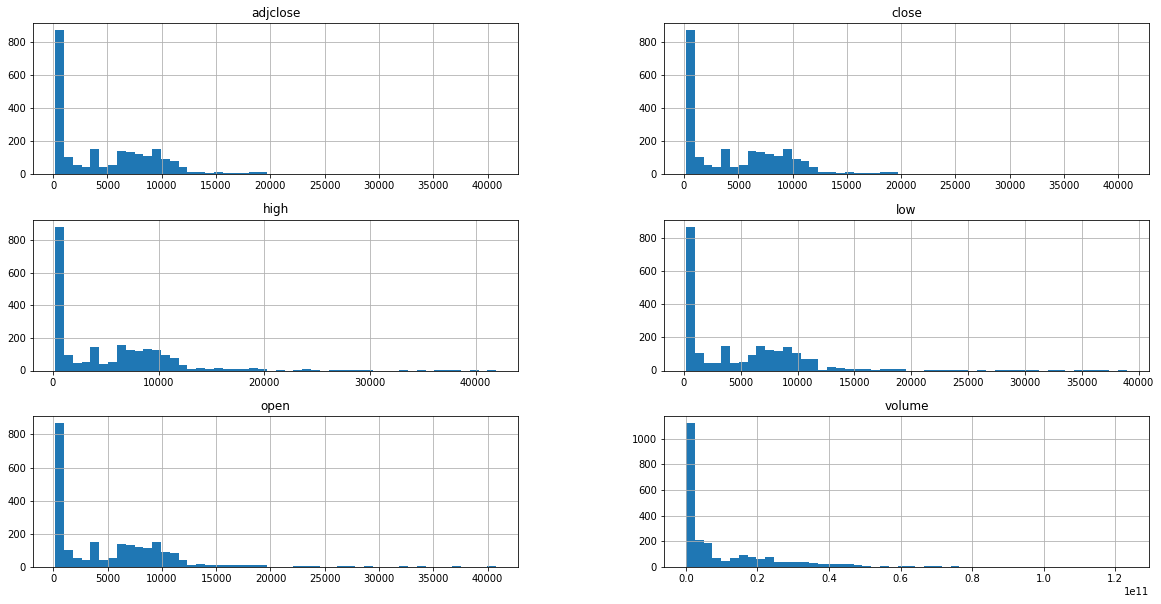

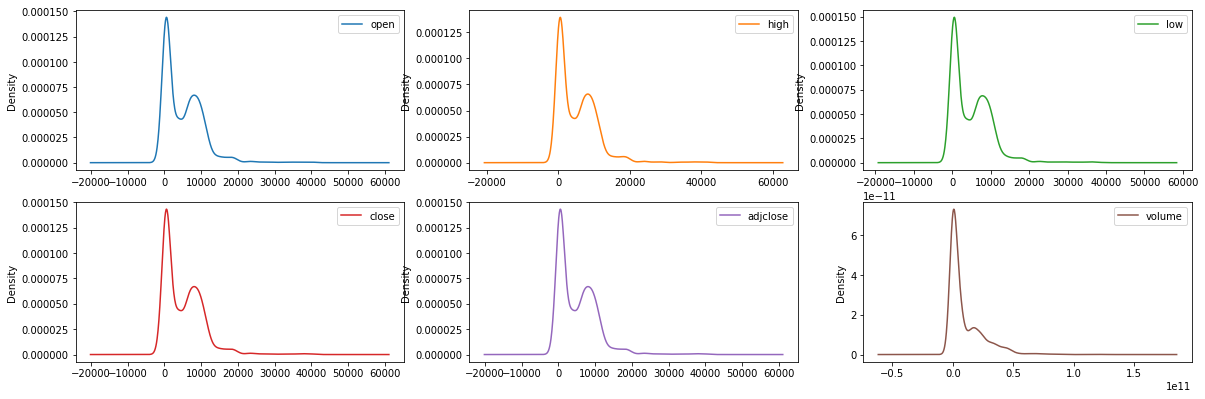

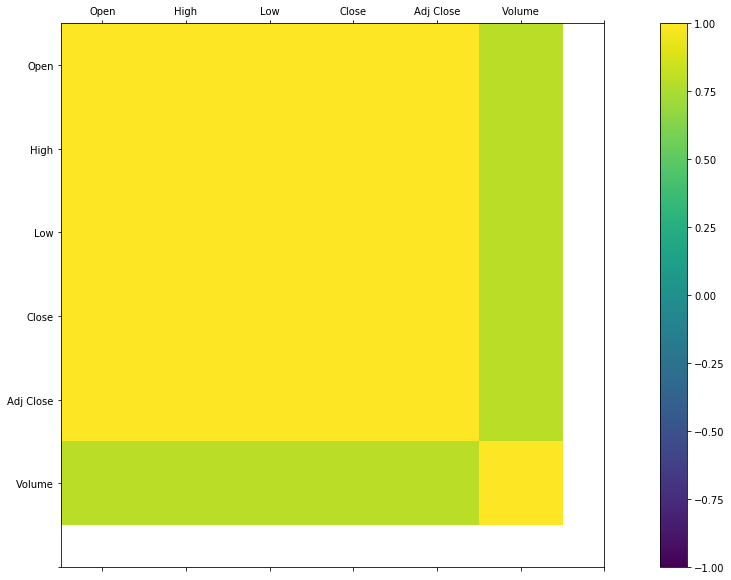

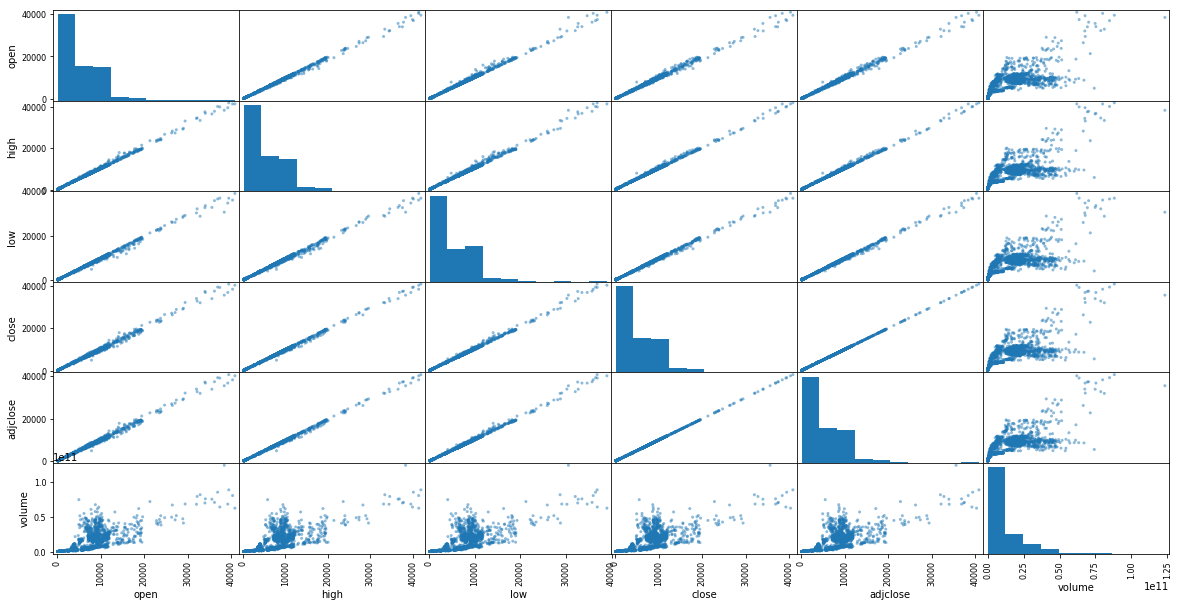

In [33]:
df = get_data("BTC-USD", index_as_date = True, interval="1d")
labels = ['Open', 'High', 'Low', 'Close','Adj Close', 'Volume']

print("Description\n",df.describe())
print("\nData Correlation\n", df.corr(method='pearson'))
print("\nStandart Deviation\n", df.std())
print("\nVariance\n", df.var())
print("\nSkewness\n", df.skew())

#Histogram
df.hist(bins=50)
plt.show()

#Skewness
df.plot(kind='density', subplots=True, layout=(3,3), sharex=False)
plt.show()

#Correlation
corr_fig = plt.figure()
axises = corr_fig.add_subplot(111)
axcorr = axises.matshow(df.corr(), vmin=-1, vmax=1)
axises.set_xticklabels(labels)
axises.set_yticklabels(labels)

corr_fig.colorbar(axcorr)
ticks = np.arange(0,7,1)

axises.set_xticks(ticks)
axises.set_yticks(ticks)
plt.show()

#Scatter Matrix Plot

scatter_matrix(df)
plt.show()

print("\nEmpty rows\n", df.isnull())